Qwen - 2d RoPE (max_head_freq=200, 10 or 1 is worse)


In [1]:
from unsloth import FastModel
import torch
from torch.nn.utils import clip_grad_value_
import torch.nn as nn
# from transformers.models.gemma3.modeling_gemma3 import Gemma3TextScaledWordEmbedding
from functions import *
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    # model_name="unsloth/gemma-3-12b-pt",
    # model_name="unsloth/gemma-3-4b-pt",
    max_seq_length = 8192, # Choose any for long context!
    load_in_4bit = True,
    resize_model_vocab=16,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.642 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/Qwen3-8B-unsloth-bnb-4bit and are newly initialized: ['model.rotary_emb.freq_x', 'model.rotary_emb.freq_y']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
model.lm_head.load_state_dict(torch.load("../../Model/qwen16.pth"))
model.model.embed_tokens.load_state_dict(torch.load("../../Model/qwen16.pth"))
# model.lm_head.load_state_dict(torch.load("../../Model/lm_heads_weights_qwen_position.pth"))
# model.model.embed_tokens.load_state_dict(torch.load("../../Model/embedding_weights_qwen_position.pth"))
model.lm_head.weight.requires_grad_(True);
model.model.embed_tokens.weight.requires_grad_(True);
model.model.rotary_emb.head_freq.requires_grad_(True);
model.train();

In [3]:
# resize model vocab
# model.model.embed_tokens = Gemma3TextScaledWordEmbedding(16,2560,0,50.59644256269407)
# model.lm_head = nn.Linear(2560, 16, bias=False)
# model.lm_head.weight = model.model.embed_tokens.weight

In [4]:
import json
output_path = '/home/zhenlan/Desktop/Projects/ARC2/Data/ARC-AGI-2-main/combined_data.json'
with open(output_path, 'r') as f:
    data = json.load(f)

In [5]:
# check for causality
# inputs = next(iter(data_gen(data, IsTrain=False, max_length=8192, autoregressive=True, NeedPosition=False, tokenize_func=tokenize_causal, IsDecode=False)))
# with torch.no_grad():
#     with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
#         out = model(inputs['input_tokens'], 
#                     # attention_mask=attention_mask,
#                     )
# logits1 = out.logits
# print(inputs['input_tokens'][0][256])
# inputs['input_tokens'][0][256] += 1
# print(inputs['input_tokens'][0][256])
# with torch.no_grad():
#     with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
#         out = model(inputs['input_tokens'], 
#                     # attention_mask=attention_mask,
#                     )
# logits2 = out.logits
# print(torch.where(torch.max(torch.abs(logits1 - logits2)[0],dim=1).values == 0))

#### Fine-tune embedding

In [6]:
epochs = 6
accumulation_steps = 32
lr = 3.5e-5
clip = 3.5e-3
MAX_LEN = 3600

In [7]:
trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr = lr, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
print(len(trainable_params))

2


In [8]:
# %debug
start_time = time.time()
train_loss = 0
val_loss = 0
for epoch in range(epochs):
    model.train()
    for i,inputs in enumerate(data_gen(data, IsTrain=True, max_length=8192, autoregressive=True, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=False, offset1=0, offset2=200)):
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
            x = inputs['input_tokens']
            y = inputs['target_tokens']
            rows = inputs['row_indices']
            cols = inputs['col_indices']
            position_ids = (rows, cols)
            yhat = model(x, position_ids=position_ids).logits
            loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        loss.backward()
        train_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_value_(trainable_params,clip)
            optimizer.step()
            optimizer.zero_grad()
    model.eval()
    for j,inputs in enumerate(data_gen(data, IsTrain=False, max_length=8192, autoregressive=False, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=False, offset1=0, offset2=200)):
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                x = inputs['input_tokens']
                y = inputs['target_tokens']
                rows = inputs['row_indices']
                cols = inputs['col_indices']
                position_ids = (rows, cols)
                yhat = model(x, position_ids=position_ids).logits
                loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        val_loss += loss.item()
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss/i:.4f} - Val Loss: {val_loss/j:.4f}")
    train_loss = 0
    val_loss = 0
end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!
Epoch 1 - Train Loss: 2.7588 - Val Loss: 2.0972
Epoch 2 - Train Loss: 2.1412 - Val Loss: 1.9573


KeyboardInterrupt: 

In [9]:
torch.save(model.lm_head.state_dict(), '../../Model/lm_heads_weights_qwen_position.pth')
torch.save(model.model.embed_tokens.state_dict(), '../../Model/embedding_weights_qwen_position.pth')

#### Fine-Tune QLORA

In [11]:
epochs = 10
accumulation_steps = 32
lr = 3e-5
clip = 3e-3
MAX_LEN = 3600

In [12]:
model.max_seq_length = MAX_LEN

In [13]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 64,           # Larger = higher accuracy, but might overfit
    lora_alpha = 64,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [14]:
trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr = lr, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
print(len(trainable_params))

504


In [15]:
# %debug
start_time = time.time()
train_loss = 0
val_loss = 0
for epoch in range(epochs):
    model.train()
    for i,inputs in enumerate(data_gen(data, IsTrain=True, max_length=8192, autoregressive=True, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=True, offset1=60, offset2=120)):
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
            x = inputs['input_tokens']
            y = inputs['target_tokens']
            rows = inputs['row_indices']
            cols = inputs['col_indices']
            position_ids = (rows, cols)
            yhat = model(x, position_ids=position_ids).logits
            loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        loss.backward()
        train_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_value_(trainable_params,clip)
            optimizer.step()
            optimizer.zero_grad()
    model.eval()
    for j,inputs in enumerate(data_gen(data, IsTrain=False, max_length=8192, autoregressive=False, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=True, offset1=60, offset2=120)):
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                x = inputs['input_tokens']
                y = inputs['target_tokens']
                rows = inputs['row_indices']
                cols = inputs['col_indices']
                position_ids = (rows, cols)
                yhat = model(x, position_ids=position_ids).logits
                loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        val_loss += loss.item()
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss/i:.4f} - Val Loss: {val_loss/j:.4f}")
    train_loss = 0
    val_loss = 0
end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Epoch 1 - Train Loss: 1.3249 - Val Loss: 1.0566
Epoch 2 - Train Loss: 1.0546 - Val Loss: 0.8320
Epoch 3 - Train Loss: 0.8207 - Val Loss: 0.6274
Epoch 4 - Train Loss: 0.6963 - Val Loss: 0.5557
Epoch 5 - Train Loss: 0.6508 - Val Loss: 0.5140
Epoch 6 - Train Loss: 0.6073 - Val Loss: 0.4646
Epoch 7 - Train Loss: 0.5764 - Val Loss: 0.4271
Epoch 8 - Train Loss: 0.5497 - Val Loss: 0.4103
Epoch 9 - Train Loss: 0.5290 - Val Loss: 0.3950
Epoch 10 - Train Loss: 0.5167 - Val Loss: 0.3798
Training completed in 127.75 minutes


In [16]:
model.save_pretrained("../../Model/merged_model_qwen_position")

/home/zhenlan/anaconda3/lib/python3.12/site-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [17]:
epochs = 10
accumulation_steps = 32
lr = 3.5e-5
clip = 3.5e-3
MAX_LEN = 3600
model.max_seq_length = MAX_LEN

In [5]:
model = PeftModel.from_pretrained(model, "../../Model/merged_model_qwen", is_trainable=True)

In [6]:
trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params,lr = lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
# %debug
start_time = time.time()
train_loss = 0
val_loss = 0
for epoch in range(epochs):
    model.train()
    for i,inputs in enumerate(data_gen(data, IsTrain=True, max_length=8192, autoregressive=True, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=True, offset1=60, offset2=120)):
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
            x = inputs['input_tokens']
            y = inputs['target_tokens']
            rows = inputs['row_indices']
            cols = inputs['col_indices']
            position_ids = (rows, cols)
            yhat = model(x, position_ids=position_ids).logits
            loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        loss.backward()
        train_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_value_(trainable_params,clip)
            optimizer.step()
            optimizer.zero_grad()
    model.eval()
    for j,inputs in enumerate(data_gen(data, IsTrain=False, max_length=8192, autoregressive=False, NeedPosition=True, tokenize_func=tokenize_causal, \
                                       IsDecode=False, ReturnLengths=False, apply_to_output=True, offset1=60, offset2=120)):
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                x = inputs['input_tokens']
                y = inputs['target_tokens']
                rows = inputs['row_indices']
                cols = inputs['col_indices']
                position_ids = (rows, cols)
                yhat = model(x, position_ids=position_ids).logits
                loss = loss_fn(yhat.view(-1,yhat.shape[-1]),y.view(-1))
        val_loss += loss.item()
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss/i:.4f} - Val Loss: {val_loss/j:.4f}")
    train_loss = 0
    val_loss = 0
end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Epoch 1 - Train Loss: 0.4750 - Val Loss: 0.3609
Epoch 2 - Train Loss: 0.4611 - Val Loss: 0.3463
Epoch 3 - Train Loss: 0.4502 - Val Loss: 0.3368
Epoch 4 - Train Loss: 0.4375 - Val Loss: 0.3235
Epoch 5 - Train Loss: 0.4306 - Val Loss: 0.3143
Epoch 6 - Train Loss: 0.4255 - Val Loss: 0.3109


KeyboardInterrupt: 

In [8]:
model.save_pretrained("../../Model/merged_model_qwen_position")

/home/zhenlan/anaconda3/lib/python3.12/site-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


#### Decoding

In [5]:
model = PeftModel.from_pretrained(model, "../../Model/merged_model_qwen", is_trainable=True)
# model = model.merge_and_unload()
FastLanguageModel.for_inference(model);

In [6]:
decoder = CausalDecoder(model, multiplier=1.2, prob_threshold=0.5, max_num_path=5)

In [7]:
start_time = time.time()
best_results, any_results = [], []
for inputs_t in data_gen(data, IsTrain=False, max_length=8192, autoregressive=True, NeedPosition=False, tokenize_func=tokenize_causal, IsDecode=True):
    decoder.decode(inputs_t,False);
    targets = inputs_t['target_tokens']
    a,b = check(decoder,targets)
    best_results.append(a)
    any_results.append(b)
    print(a,b)
end_time = time.time()
print(f"Best results: {sum(best_results)/len(best_results)}")
print(f"Any results: {sum(any_results)/len(any_results)}")
print(f"Best results exact match: {sum([res == 1 for res in best_results])/len(best_results)}")
print(f"Any results exact match: {sum([res == 1 for res in any_results])/len(any_results)}")
print(f"Completed in {(end_time - start_time)/60:.2f} minutes")

0.9476813317479191 0.9476813317479191
0.6849999999999999 0.6849999999999999
0 0
0 0
0.3888888888888889 0.6140350877192983
0 0
0.9081632653061223 0.9107142857142857
0.9288888888888889 0.9511111111111111
0.8412698412698413 0.8412698412698413
0.9751552795031057 0.9772256728778468
0.7277777777777777 0.7277777777777777
0 0.375
0.9333333333333332 0.9333333333333332
0.9577777777777778 0.9577777777777778
0.7120743034055728 0.7585139318885449
0 0
0.8600823045267489 0.8600823045267489
0.8544444444444445 0.861111111111111
0.8699999999999999 0.8800000000000001
0 0
0.8095238095238095 0.8095238095238095
0 0
0.8305785123966942 0.8305785123966942
0.7823275862068966 0.8491379310344828
0.8552631578947368 0.8552631578947368
0 0
0 0.8727810650887574
0.9765625 0.9765625
0.6833333333333333 0.6833333333333333
0.8 0.8323809523809524
0.7638888888888888 0.8333333333333334
0.97 0.97
0.75 0.75
0 0
0.8222222222222223 0.8222222222222223
0 0
0 0
0.98125 0.98125
0.9199999999999999 0.9199999999999999
0 0
0.94173602853

In [16]:
attention.across_grid_attn_bias.grad

torch.Size([1, 32, 60, 60])

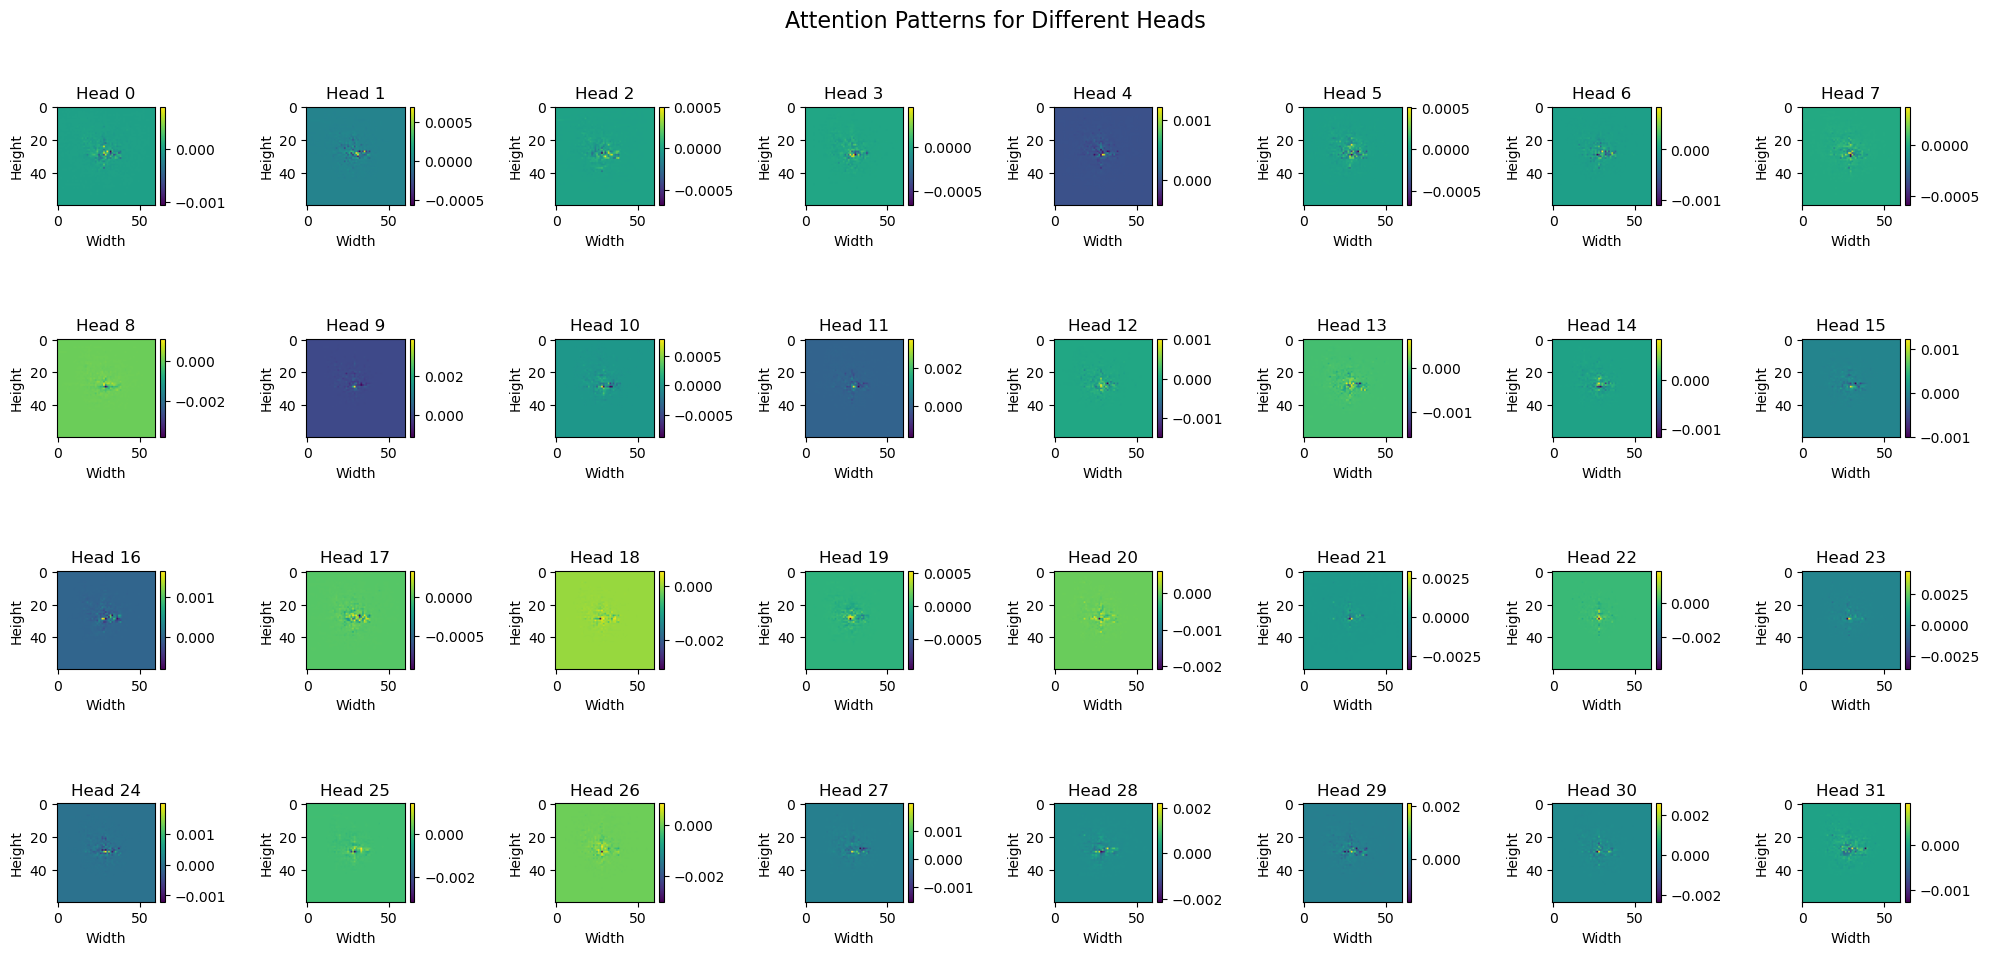

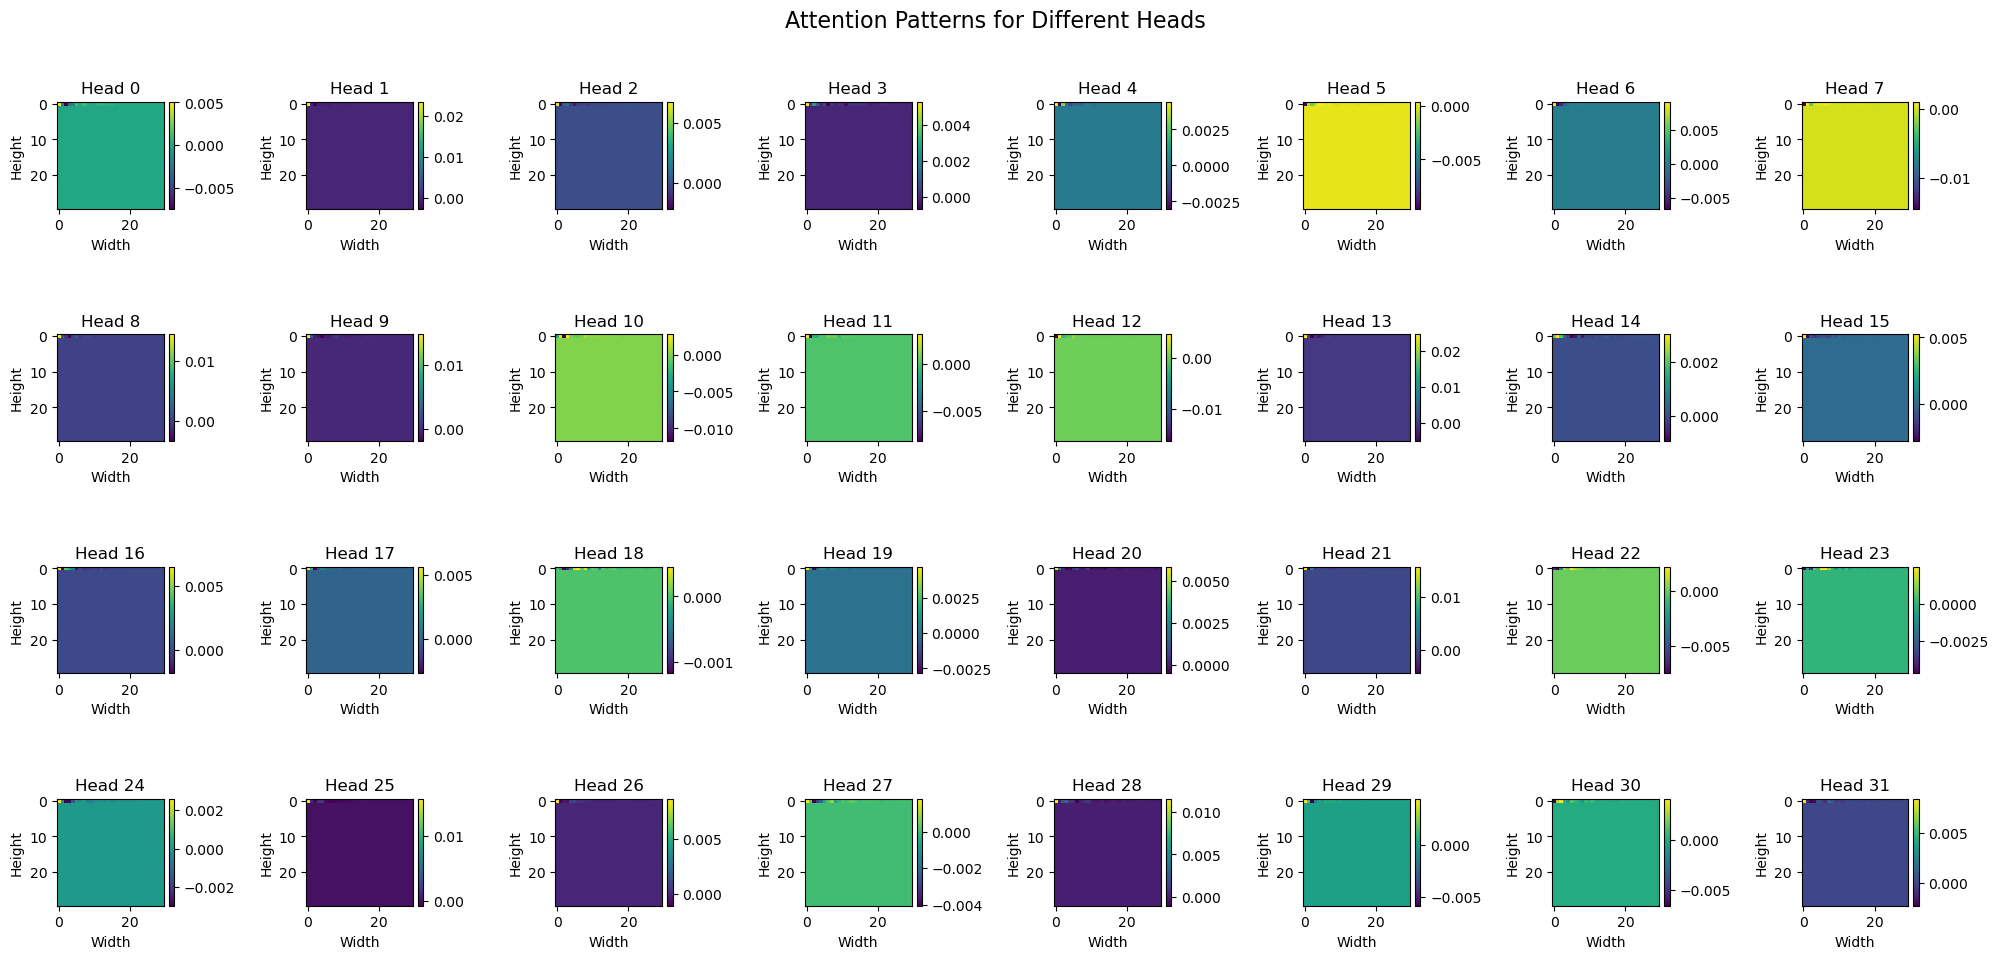

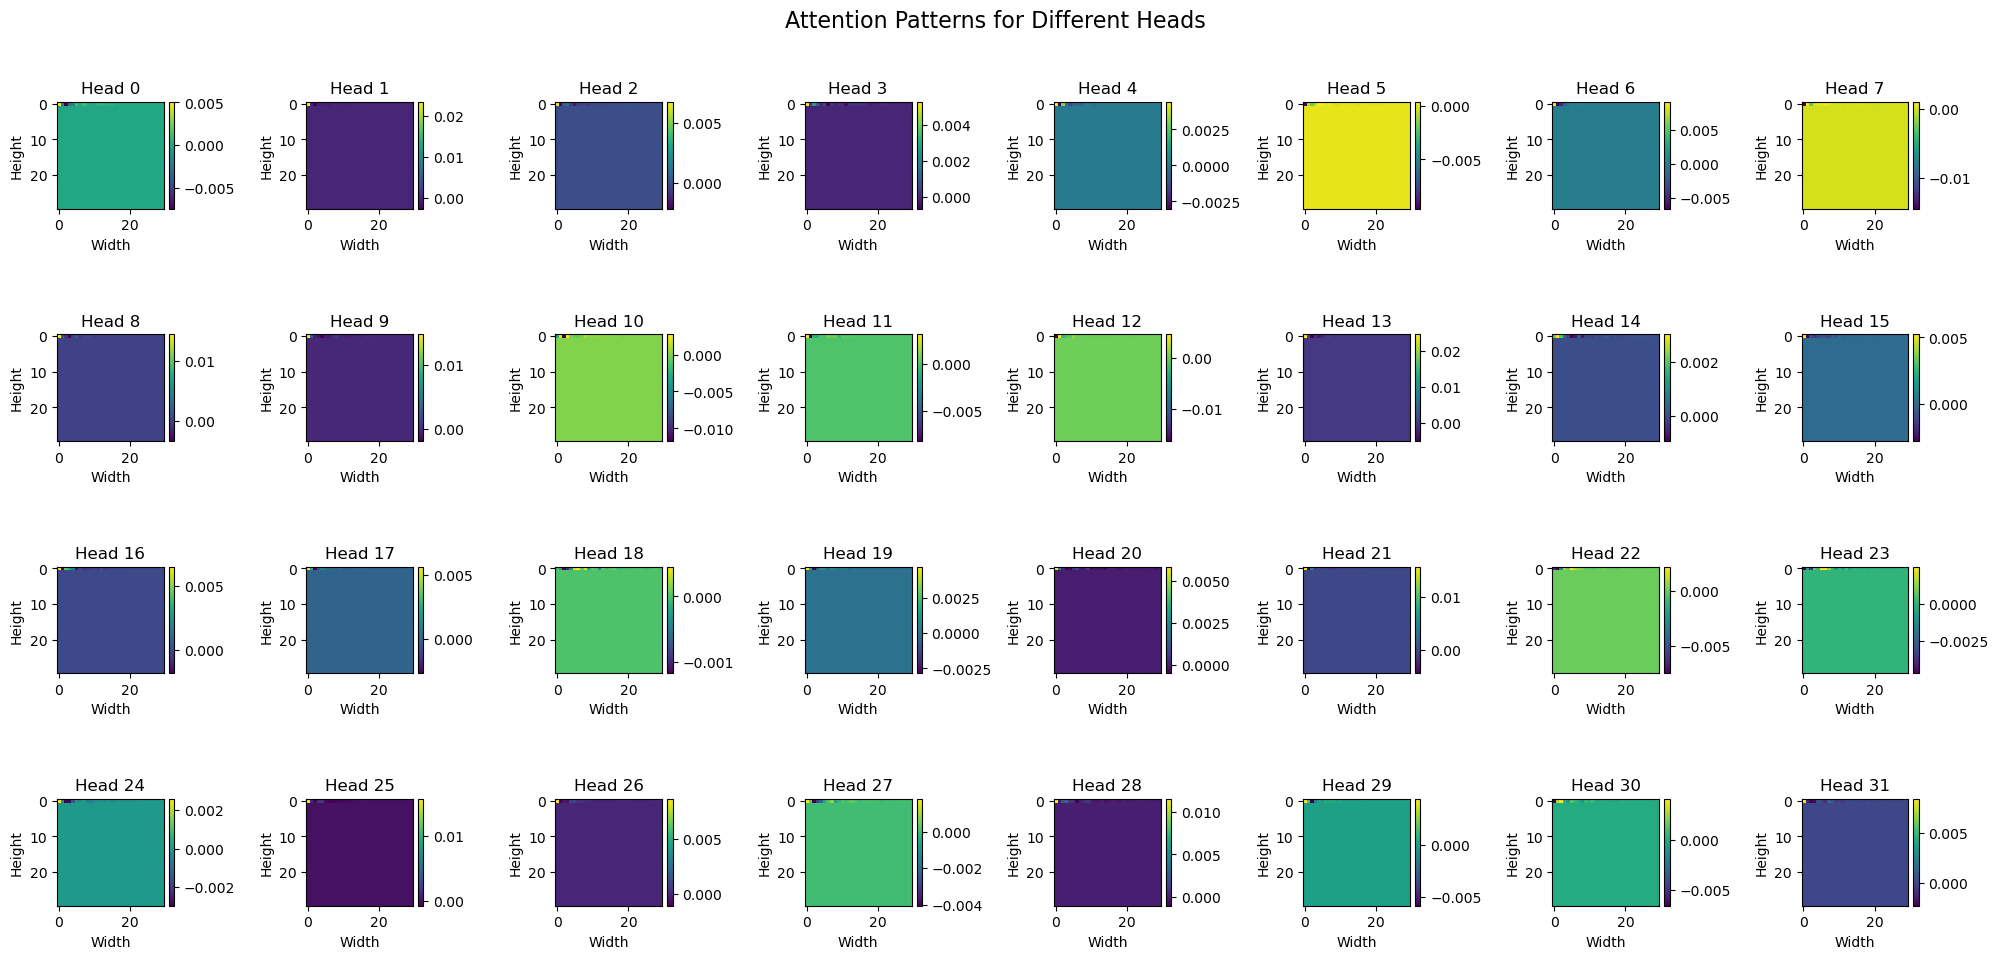

In [18]:
# Call the function with the pattern data
plot_attention_patterns(attention.across_grid_attn_bias.grad, 0)
plt.show()
plot_attention_patterns(attention.within_grid_attn_bias.grad, 0)